<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>

<h1>MPO 624: Histograms and PDFs</h1>
### Statistics Homework 15 Feb 2018
### Rachel Zelinsky

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### Ways of estimating a PDF from some numbers
1. <a href="#histograms">Histograms</a>
1. <a href="#kernels">Kernels</a>

In [1]:
import matplotlib as mpl
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Math, Latex
from numpy.random import rand
from pylab import rcParams, pcolor, show,colorbar, xticks, yticks, title, figure
from IPython.display import Image
from netCDF4 import Dataset

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

from wrf import to_np, getvar, smooth2d, get_cartopy, cartopy_xlim, cartopy_ylim, latlon_coords


# Get data from remote server 

In [2]:
# Get data from a remote machine.
import os
import paramiko 
ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect('manta.rsmas.miami.edu', username="rsodowsky", password="Lilly3600")
sftp = ssh.open_sftp()
localpath = '/Users/newumuser/Documents/GitHub/MPO624_DataAnalysis/DATA/coup_ctl/wrfout_d01_2011-11-01_00:00:00'
remotepath = '/home/disk/uwin1/rsodowsky/ctr_wrf/coup_ctl_18Oct2011/wrfout_d01_2011-11-01_00:00:00'
sftp.get(remotepath, localpath)
sftp.close()
ssh.close()

# Read the WRF file and make a lat-lon plot to see what is going on

Text(0.5,1,'Skin Temperature and Maximum Reflectivity')

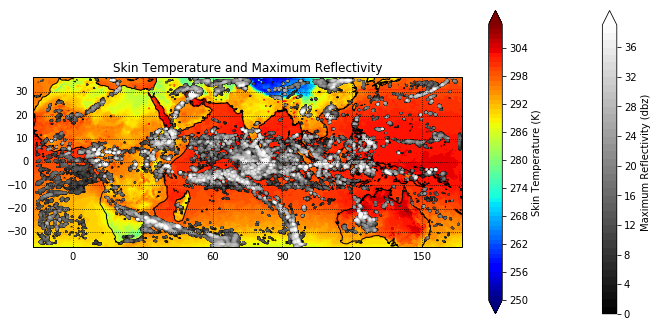

In [2]:
# Read WRF netcdf file
ncfile = Dataset('/Users/newumuser/Documents/GitHub/MPO624_DataAnalysis/DATA/coup_ctl/wrfout_d01_2011-11-01_00:00:00')
skin_t = getvar(ncfile, "TSK")
mdbz = getvar(ncfile, "mdbz")#, meta=False)
# Get the latitude and longitude points
lats, lons = latlon_coords(skin_t)
# Get the cartopy mapping object
cart_proj = get_cartopy(skin_t)

# Create a figure
fig = plt.figure(figsize=(12,9))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=crs.PlateCarree())

# Download and add the states and coastlines
states = NaturalEarthFeature(category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax.add_feature(states, linewidth=.5)
ax.coastlines('50m', linewidth=0.8)


# Make the contour outlines for skin temp and filled contour for reflectivity
c1 = plt.contourf(to_np(lons), to_np(lats), to_np(mdbz), levels = np.arange(0,40,1), transform=crs.PlateCarree(),
             cmap=get_cmap("gray"),extend="max") #to get the filled colorbar
plt.contour(to_np(lons), to_np(lats), to_np(mdbz), levels = np.arange(0,40,1), transform=crs.PlateCarree(),
             cmap=get_cmap("gray"),extend="max")
c2 = plt.contourf(to_np(lons), to_np(lats), to_np(skin_t), levels = np.arange(250,310,1), cmap=get_cmap("jet"),
            transform=crs.PlateCarree(),extend="both")

# Add a color bar
c1_bar = plt.colorbar(c1,ax=ax, shrink=.62)
c2_bar = plt.colorbar(c2,ax=ax, shrink=.62)
c1_bar.set_label("Maximum Reflectivity (dbz)")
c2_bar.set_label("Skin Temperature (K)")
g1 = ax.gridlines(crs.PlateCarree(),color="black", linestyle="dotted", draw_labels="true")
g1.ylabels_right = False
g1.xlabels_top = False
plt.title("Skin Temperature and Maximum Reflectivity")



# Now make a 2D histogram of the data

Text(0.5,1,'Joint PDF of Skin Temperature and Max Reflectivity')

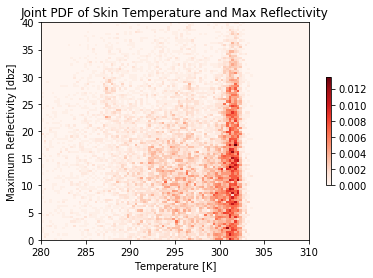

In [3]:
import matplotlib.cm as cm  # import the colormaps.
fig,ax=plt.subplots(1,1)    # Create a result-shaped container (a fig)
skin_t = getvar(ncfile, "TSK", meta=False)
mdbz = getvar(ncfile, "mdbz", meta=False)
# Make the 2D histogram 
skin_t_1D = np.reshape(skin_t,(np.size(skin_t)))
mdbz_1D = np.reshape(mdbz,(np.size(mdbz))); 

(n,xx,yy,im)=ax.hist2d(skin_t_1D, mdbz_1D,bins=100,cmap=cm.Reds,cmin=0.,normed=True,range=[[280,310],[0,40]])

# Plot it, with a colorbar
plt.colorbar(im,shrink=0.5)
ax.set_xlabel('Temperature [K]'); ax.set_ylabel('Maximum Reflectivity [dbz]')
ax.set_title('Joint PDF of Skin Temperature and Max Reflectivity')
#plt.show()

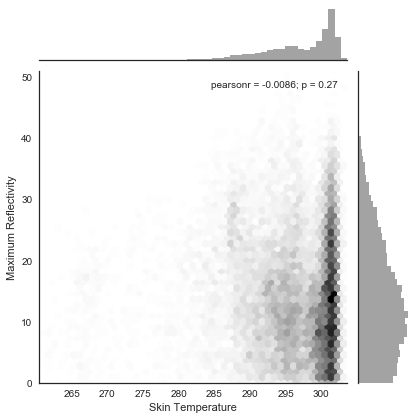

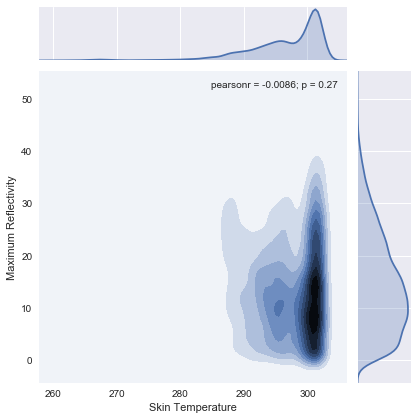

In [4]:
# Do it in Seaborn, with the marginal distributions on the top and side
import seaborn as sns
sns.set(color_codes=True)

#only consider maximum reflectivity greater than 0
mdbz_nan = mdbz_1D
mdbz_nan[mdbz_nan < 0] = np.nan

df = pd.DataFrame({'Skin Temperature': skin_t_1D, 'Maximum Reflectivity': mdbz_nan})
with sns.axes_style("white"):
    sns.jointplot(x="Skin Temperature", y="Maximum Reflectivity", data=df, kind="hex", color="k");
sns.jointplot(x="Skin Temperature", y="Maximum Reflectivity", data=df, kind="kde")

#### Big question: *How many bins?* 

There are many ways, but one rule of thumb is the **Freedman-Diaconis rule**. For this, you compute the Inter-Quartile-Range (IQR). 
If there are 1500 data points, you lay them out in ascending order... and take the 375th term (the one 25% of the way along)
and the 1125th term (the one 75% of the way along). This is the IQR. You also know N, the number of samples, which in this case in 1500. Now double it.

$BinSize = 2\frac{value(1125)-value(375)}{^{3}\sqrt{1500}}$

In [12]:
# Let's try that rule of thumb for surface temperature histogram bins

q75, q25 = np.percentile(skin_t_1D, [75 ,25])
print('q75:',q75,'q25:',q25)
iqr = q75 - q25
fdr = (2.*np.ceil(iqr))/(np.power(len(skin_t_1D),1./3))
print ('optimal # of bins: ', np.ceil(fdr))

q75: 300.55548095703125 q25: 291.65699768066406
optimal # of bins:  1.0


In [10]:
# Let's try that rule of thumb for maximum reflectivity

q75, q25 = np.nanpercentile(mdbz_1D, [75 ,25])
print('q75:',q75,'q25:',q25)
iqr = q75 - q25
fdr = (2.*np.ceil(iqr))/(np.power(len(mdbz_1D),1./3))
print ('optimal # of bins: ', np.ceil(fdr))

q75: 20.828885078430176 q25: 7.169349908828735
optimal # of bins:  1.0


The "rule of thumb" doesn't always work...

#### Approximate correlation coefficient

This is calculated as usually taught:

\begin{equation}
      r_{xy} = \frac{s_{xy}}{s_xs_y} =\frac{1}{N-1}\frac{\sum_{i=1}^N (x_i-\overline{x})(y_i-\overline{y})}{s_xs_y}
\end{equation}
The correlation coefficient is constrained for fall in the range $\pm 1$. A value of +1 tells us that the
points $(x_i, y_i)$ define a straight line with a positive slope. A value of -1 tells us that the points $(x_i,
y_i)$ define a straight line with a negative slope. A value of 0 shows that there is no dependence of
$y$ on $x$ or vice versa (i.e., no correlation).

It is important to note that $r$ measures the strength of the linear relationship between $x$ and $y$ but a high value of |$r$| does not necessarily imply a cause and effect relationship or that the two variables are linearly related. It is easy to devise non-linear relationships that give a high
correlation coefficient. It is important to look at the data and use common sense.

Note, of course, that $r_{xy}$ is a random variable, and therefore has a probability distribution function, means, and variances.  It therefore is subject to confidence intervals. 

A smart person named Fisher figured out that if we consider the function of $r_{xy}=r$

\begin{equation}
    F(r)=\mathrm{arctanh}(r)
\end{equation}
then $F(r)$ approaches a Normal distribution as $N\to\infty$, with a standard deviation of $\sigma_F=\frac{1}{\sqrt{N-3}}$.

So, if we calculate $r$, then the 95% confidence interval for $F(r)$ is $\pm 1.96/\sqrt{N-3}$, and we can calculate the confidence intervals on $r$ by taking $\tanh\left(F(r)\pm1.96/\sqrt{N-3}\right)$.  (Remember the 95% confidence intervals for a Gaussian with standard deviation of 1 is $\pm1.96$)

Consider the example with the same data (detailed):

In [9]:
N=skin_t.size
ntosig=.5
x = skin_t;x=x-np.nanmean(x)
y = mdbz;y=y-np.nanmean(y)
r = np.nansum(x*y)/np.nanstd(x,ddof=1)/np.nanstd(y,ddof=1)/(N-1)
print (r)
F = np.arctanh(r)
Fp95 = F+1.96/np.sqrt(N-3)
Fm95 = F-1.96/np.sqrt(N-3)
rp=np.tanh(Fp95)
rm=np.tanh(Fm95)
print ("r= %1.3f (%1.3f,%1.3f)"%(r,rm,rp))


-0.0012539031395528367
r= -0.001 (-0.007,0.005)


All the plots and the correlation coefficient show surface temperature and reflectivity do not have a linear relationship. However, there is a "sensible" or intuitive relationship where reflectivity greater than 0dBZ (clouds and rain) occurs over warmer temperatures.